In [3]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def f(x):
    return 3*x**2 - 4*x + 5

In [5]:
f(3.0)

20.0

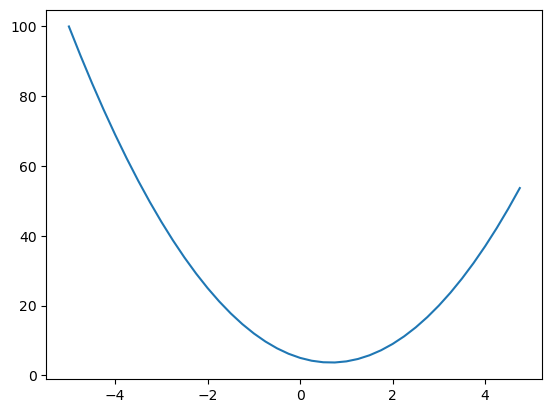

In [6]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [7]:
h = 0.00000001
x = 2/3
(f(x+h) - f(x))/h

0.0

In [8]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [9]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c

c += h

d2 = a*b + c
print('d1',d1)
print('d2',d2)
print('slope',(d2-d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [10]:
class Value:

    def __init__(self,data, _children = (), _op = '',label = ''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda:None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"
    
    def __add__(self, other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
    
        return out
    
    def __radd__(self, other):
        return self + other

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return other + (-self)

    def __mul__(self, other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self, other):
        return self * other


    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/ (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
    
        def _backward():
            self.grad += out.grad * (1 - t**2)
        out._backward = _backward

        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,),'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out 
    
    def  __pow__(self, other):
        assert isinstance(other, (int,float))
        out = Value(self.data**other, (self,),f'**{other}')

        def _backward():
            self.grad += other*self.data**(other-1) * out.grad
        out._backward = _backward

        return out
    
    def __truediv__(self, other):
        return self * other **-1
    
    def __rtruediv__(self, other):
        return other * self**-1

    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [11]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir':'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape = 'record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot


In [12]:
x1 = Value(2.0, label= 'x1')
x2 = Value(0.0, label = 'x2')
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

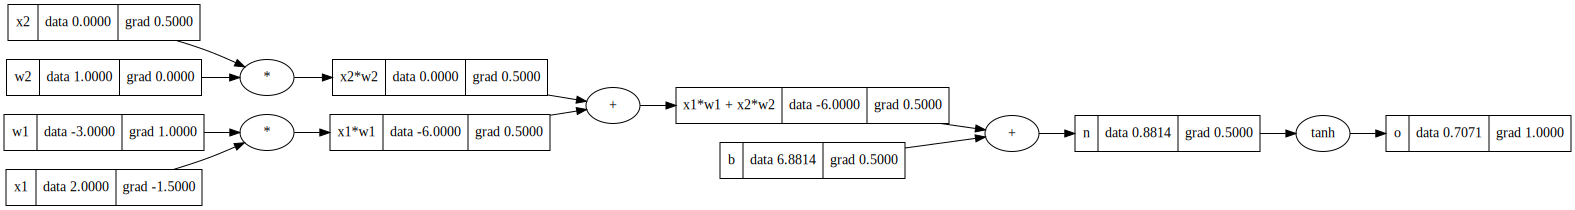

In [13]:
draw_dot(o)

In [14]:
x1 = Value(2.0, label= 'x1')
x2 = Value(0.0, label = 'x2')
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp(); e.label = 'e'
o = (e - 1)/(e + 1); o.label = 'o'
o.backward()

In [15]:
o

Value(data=0.7071067811865477, grad=1.0)

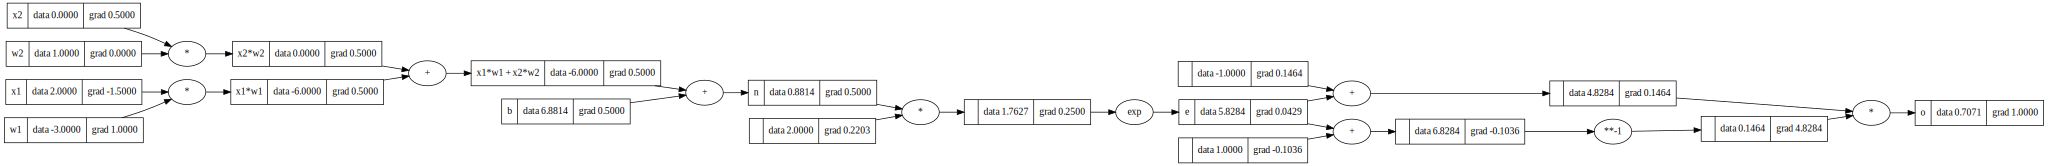

In [16]:
draw_dot(o)

#### Implementing using Pytorch

In [17]:
import torch

In [18]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True

n = x1*w1 + x2*w2 + b

In [19]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [20]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):

        act = sum(wi*xi for wi,xi in zip(self.w,x)) + self.b
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x 
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [21]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.3259506078151876, grad=0.0)

In [22]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

In [23]:
for k in range(20):

    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((ygt - yout)**2 for ygt, yout in zip(ys, ypred))

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update
    for p in n.parameters():
        p.data -= 0.05*p.grad
    
    print(k, loss.data)

0 5.034560183673876
1 3.2732190265894356
2 2.7102337629093007
3 2.0229641232791966
4 1.3870101407598836
5 0.9371779369031396
6 0.6587172914296312
7 0.48757232438012965
8 0.3777120236924384
9 0.3034527704938854
10 0.2508692155217185
11 0.21214880510285622
12 0.18269762395125644
13 0.15968668845381392
14 0.14129953369676485
15 0.12632620786718873
16 0.11393457355615581
17 0.10353617789217634
18 0.09470464810020617
19 0.08712438315556181


#### Test

In [50]:
def test_sanity_check():
    x = Value(-4.0)
    z = 2 * x + 2 + x
    q = z.tanh() + z * x
    h = (z * z).tanh()
    y = h + q + q * x
    y.backward()
    xmg, ymg = x, y

    x = torch.Tensor([-4.0]).double()
    x.requires_grad = True
    z = 2 * x + 2 + x
    q = z.tanh() + z * x
    h = (z * z).tanh()
    y = h + q + q * x
    y.backward()
    xpt, ypt = x, y

    assert xmg.grad == xpt.grad.item()
    assert ymg.data == ypt.data.item()

In [51]:
test_sanity_check()

#### Demo

In [53]:
np.random.seed(1337)
random.seed(1337)

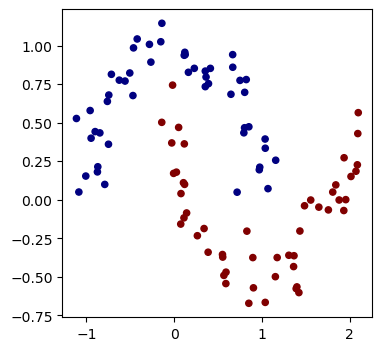

In [58]:
from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)
y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(4,4))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [61]:
model = MLP(2,[16,16,1])

In [ ]:
def loss(batchsize = None):
    if batchsize == None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batchsize]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]

    


    

In [62]:
ri = np.random.permutation(X.shape[0])[:20]

In [65]:
Xb = X[ri]
Xb

array([[ 0.66727537,  0.94137342],
       [ 0.9706518 ,  0.19480437],
       [ 1.03844059, -0.66505615],
       [-0.84666874,  0.43388322],
       [ 1.39098104, -0.5758291 ],
       [ 0.66820133,  0.85951501],
       [ 2.08851394,  0.22694773],
       [-0.46974417,  0.67596757],
       [ 1.36628765, -0.36251519],
       [ 0.12601376,  0.94138852],
       [ 1.937237  ,  0.27275735],
       [ 0.82921179, -0.20315015],
       [ 0.64763829,  0.68430587],
       [ 0.0512925 ,  0.46948253],
       [-0.62539273,  0.77586202],
       [ 1.758169  , -0.0654567 ],
       [ 0.75069279,  0.77439447],
       [-0.94676465,  0.39955043],
       [ 1.154022  , -0.49842544],
       [ 1.43362304, -0.20234959]])

In [68]:
inputs = [list(map(Value, xrow)) for xrow in Xb]

In [69]:
list(map(model, inputs))

[Value(data=-0.05856470099116771, grad=0.0),
 Value(data=-0.3746492670007949, grad=0.0),
 Value(data=-0.9640889195199437, grad=0.0),
 Value(data=-0.9550974700818524, grad=0.0),
 Value(data=-0.9137607419540492, grad=0.0),
 Value(data=-0.14655726335718566, grad=0.0),
 Value(data=0.6109647152847407, grad=0.0),
 Value(data=-0.9372094898110055, grad=0.0),
 Value(data=-0.8394217947673708, grad=0.0),
 Value(data=-0.5892357201604962, grad=0.0),
 Value(data=0.5261545075182974, grad=0.0),
 Value(data=-0.7866486239150104, grad=0.0),
 Value(data=-0.3363660983419449, grad=0.0),
 Value(data=-0.8483116595012362, grad=0.0),
 Value(data=-0.9453071872910473, grad=0.0),
 Value(data=-0.11645068299708677, grad=0.0),
 Value(data=-0.15401280925789235, grad=0.0),
 Value(data=-0.9504953430196904, grad=0.0),
 Value(data=-0.9345859084193395, grad=0.0),
 Value(data=-0.6610955174556286, grad=0.0)]